# Data Science HandBook - By Keivan Ipchi Hagh

##### Test Data

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_dataset = pd.read_csv('https://raw.githubusercontent.com/keivanipchihagh/keivanipchihagh/main/Data%20Science%20HandBook%20Files/train.csv')
test_dataset = pd.read_csv('https://raw.githubusercontent.com/keivanipchihagh/keivanipchihagh/main/Data%20Science%20HandBook%20Files/test.csv')

X = train_dataset.copy()
y = train_dataset['SalePrice']

def copy_data():
  return train_test_split(X, y, train_size = 0.8, random_state = 0)

def copy_data_numerics():
  _X = X.copy().select_dtypes(exclude = ['object'])
  return train_test_split(_X, y, train_size = 0.8, random_state = 0)

## Data Processing

### Parsing Dates

In [ ]:
# Normaly it's done like this
landslides['date_parsed'] = pd.to_datetime(landslides['date'], format="%m/%d/%y")

# Incase you face an error saying there are multiple date formats, use:
landslides['date_parsed'] = pd.to_datetime(landslides['Date'], infer_datetime_format=True)

### Missing Values

#### 1) Drop Columns with Missing Values

Unless most values in the dropped columns are missing, the model loses access to a lot of (potentially useful!) information with this approach.

In [ ]:
X_train, X_valid, y_train, y_valid = copy_data()

# Get names of columns with missing values
cols_with_missing = [col for col in X_train.columns if X_train[col].isnull().any()]

# Drop columns in training and validation data
reduced_X_train = X_train.drop(cols_with_missing, axis = 1)
reduced_X_valid = X_valid.drop(cols_with_missing, axis = 1)

#### 2) Imputation

Imputation fills in the missing values with some number. For instance, we can fill in the mean value along each column. The imputed value won't be exactly right in most cases, but it usually leads to more accurate models than you would get from dropping the column entirely.

**Note that Imutation drops the column names. Put the back!**

In [ ]:
from sklearn.impute import SimpleImputer

X_train, X_valid, y_train, y_valid = copy_data_numerics()

# Imputation
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))

# Imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

#### 3) An Extension To Imputation

Imputation is the standard approach, and it usually works well. However, imputed values may be systematically above or below their actual values (which weren't collected in the dataset). Or rows with missing values may be unique in some other way. In that case, your model would make better predictions by considering which values were originally missing. **In some cases, this will meaningfully improve results. In other cases, it doesn't help at all.**

**Note that this method remvoes the column names. Remember to put them back!**

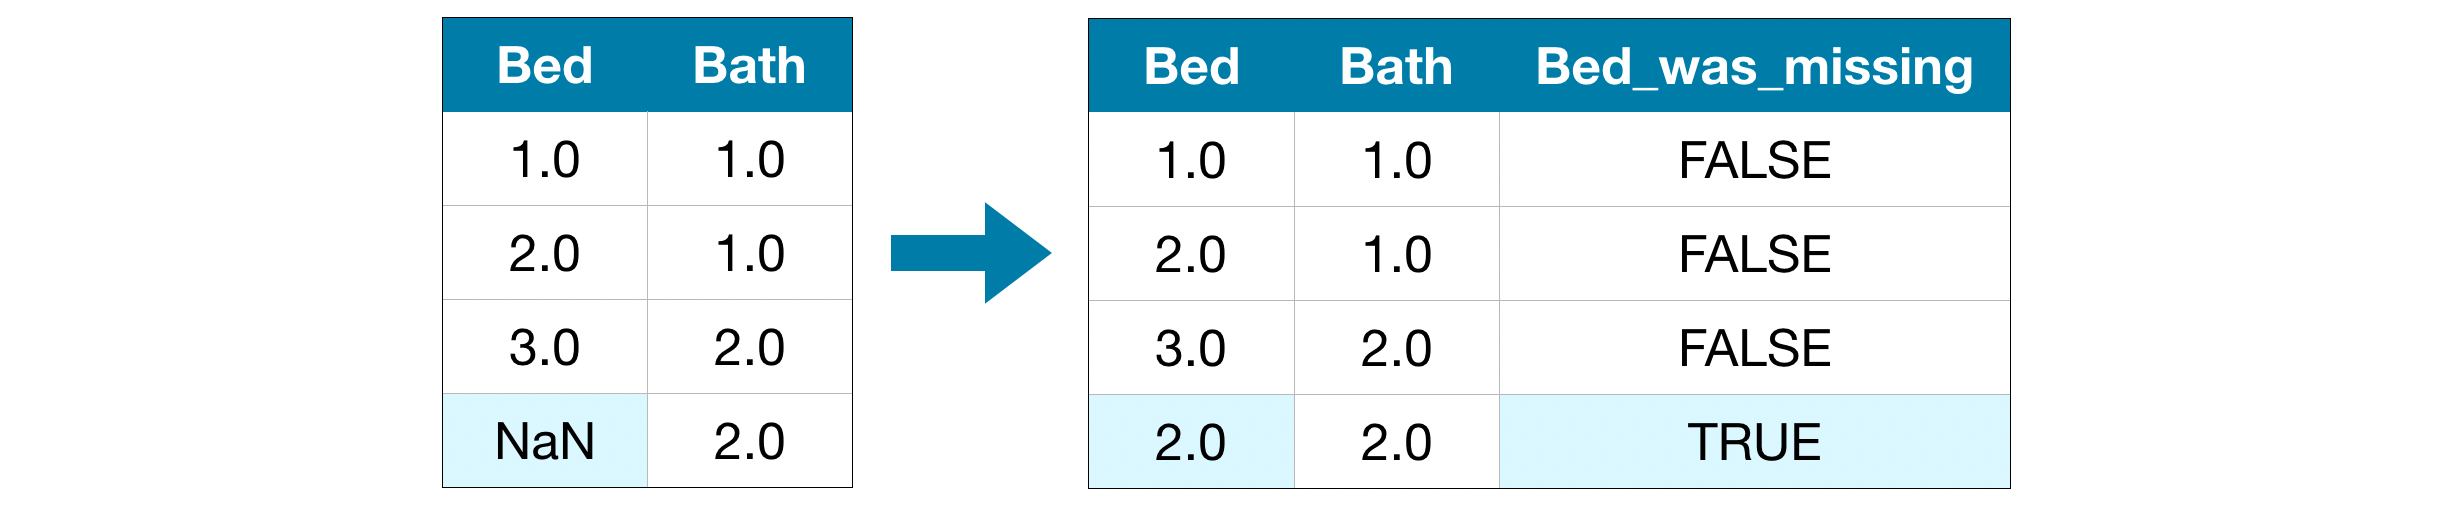

In [ ]:
from sklearn.impute import SimpleImputer

X_train, X_valid, y_train, y_valid = copy_data_numerics()

# Get names of columns with missing values
cols_with_missing = [col for col in X_train.columns if X_train[col].isnull().any()]

# Make new columns indicating what will be imputed
for col in cols_with_missing:
    X_train[col + '_was_missing'] = X_train[col].isnull()
    X_valid[col + '_was_missing'] = X_valid[col].isnull()

# Imputation
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))

# Imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

### Categorical Variables

#### 1) Drop Categorical Variables

Easiest though dangerous approch is to simply drop the columns 

In [ ]:
X_train, X_valid, y_train, y_valid = copy_data()

X_train = X_train.select_dtypes(exclude = ['object'])
X_valid = X_valid.select_dtypes(exclude = ['object'])

#### 2) Label Encoding

LabelEncoder can turn **[dog, cat, dog, mouse, cat]** into **[1, 2, 1, 3, 2]**, but then the imposed ordinality means that the average of dog and mouse is cat. Still there are algorithms like decision trees and random forests that can work with categorical variables just fine and LabelEncoder can be used to store values using less disk space.

**So use LabelEncoding for ordinal variables!**

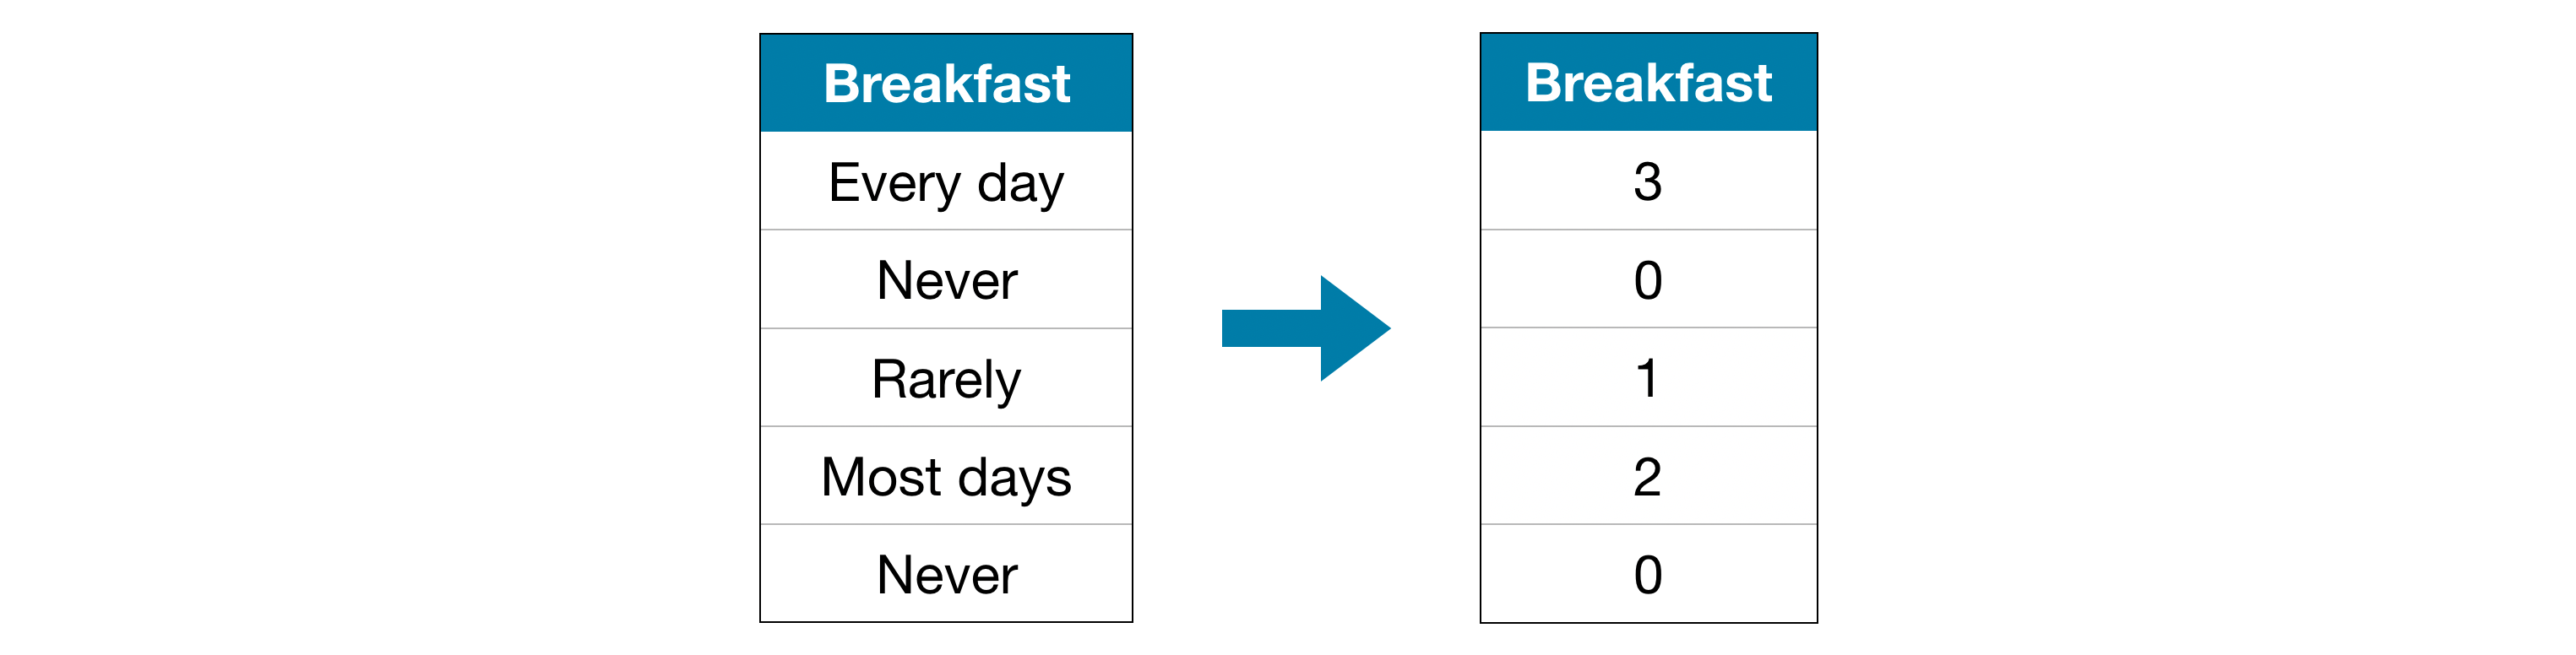

In [ ]:
from sklearn.preprocessing import LabelEncoder

X_train, X_valid, y_train, y_valid = copy_data_numerics()

object_cols = X_train.select_dtypes(['object']).columns

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
label_X_train, label_X_valid = X_train.copy(), X_valid.copy()

for col in object_cols:
    label_X_train[col] = label_encoder.fit_transform(X_train[col])  # Fit
    label_X_valid[col] = label_encoder.transform(X_valid[col])      # Transform quantities

#### 3) One-Hot Encoding

One-Hot-Encoding has the advantage that the result is binary rather than ordinal and that everything sits in an orthogonal vector space. The disadvantage is that for high cardinality, the feature space can really blow up quickly and you start fighting with the curse of dimensionality. In these cases, I typically employ one-hot-encoding followed by PCA for dimensionality reduction. I find that the judicious combination of one-hot plus PCA can seldom be beat by other encoding schemes. PCA finds the linear overlap, so will naturally tend to group similar features into the same feature.

**One-Hot-Encoding is more efficient when facing ordinal variables!**

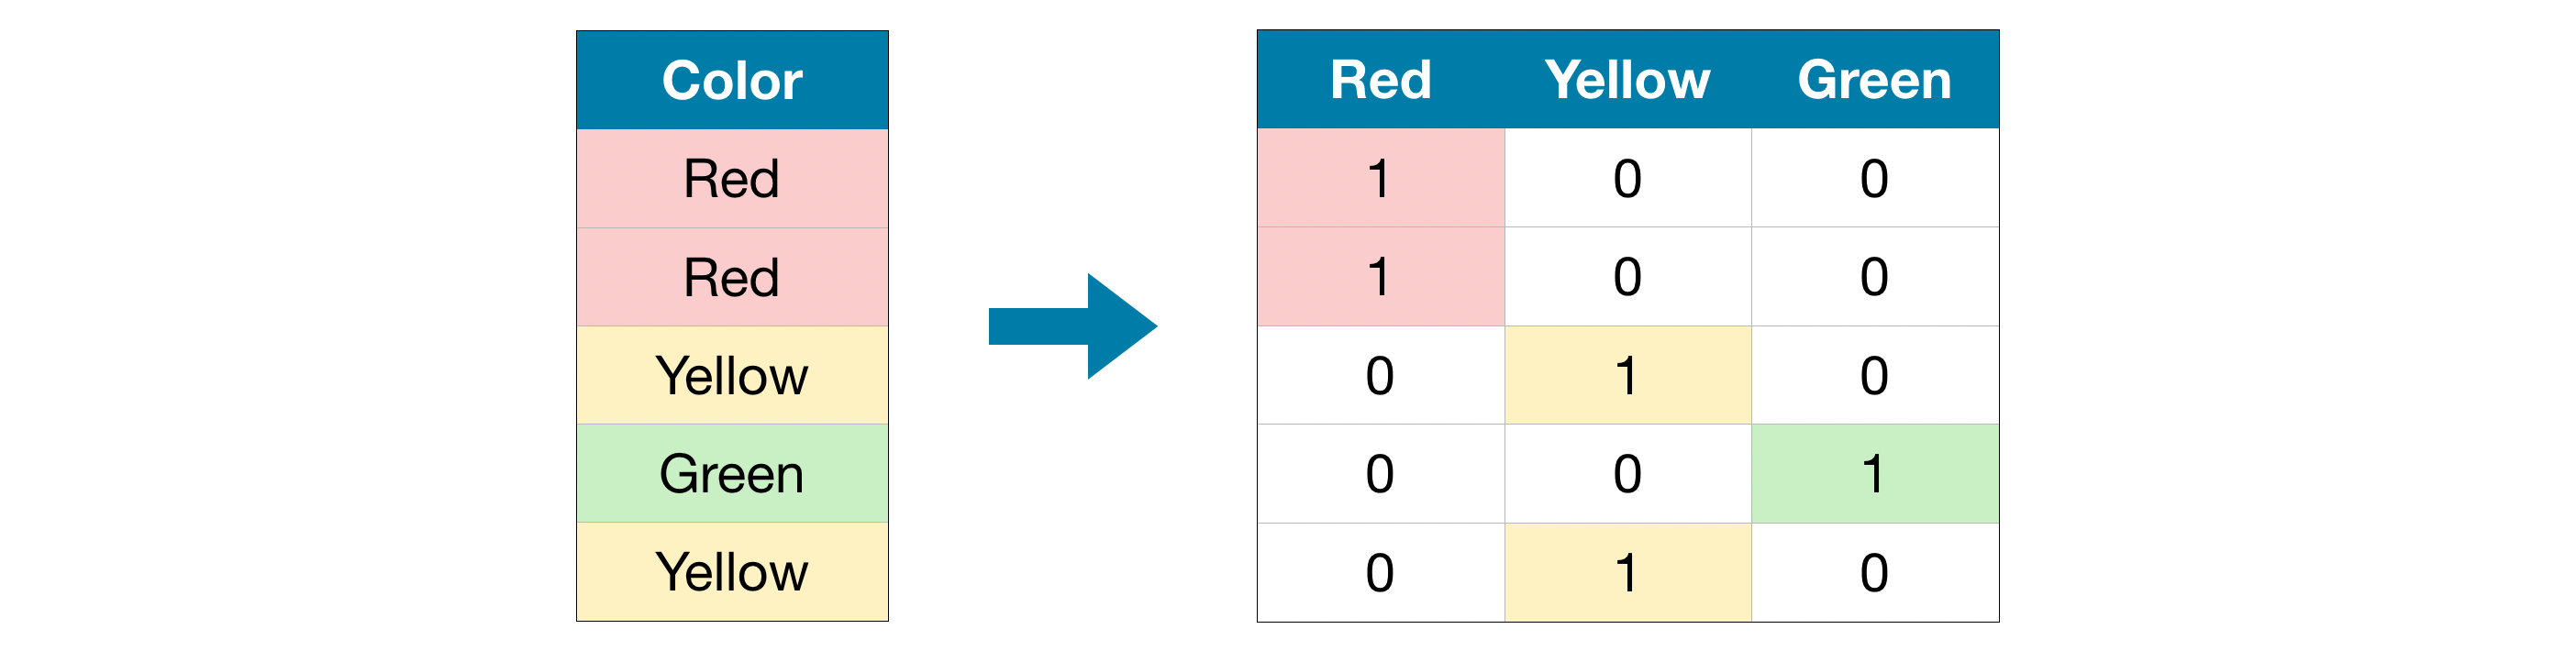

In [ ]:
from sklearn.preprocessing import OneHotEncoder

X_train, X_valid, y_train, y_valid = copy_data_numerics()

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis = 1)
num_X_valid = X_valid.drop(object_cols, axis = 1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis = 1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis = 1)

### Cross-Validation

Cross-validation gives a more accurate measure of model quality, which is especially important if you are making a lot of modeling decisions. However, it can take longer to run, because it estimates multiple models (one for each fold).

So, given these tradeoffs, when should you use each approach?

- For small datasets, where extra computational burden isn't a big deal, you should run cross-validation.
- For larger datasets, a single validation set is sufficient. Your code will run faster, and you may have enough data that there's little need to re-use some of it for holdout.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# prepare the cross-validation procedure

X_train, X_valid, y_train, y_valid = copy_data_numerics()

cv = KFold(n_splits = 10, random_state = 1, shuffle = True)

# evaluate model
scores = cross_val_score(model, X_train, X_valid, scoring = 'accuracy', cv = cv, n_jobs = -1)

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

## Models

### Random Forests

In [ ]:
# Imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

X_train, X_valid, y_train, y_valid = copy_data_numerics()

# Initialize Tree
forest_model = RandomForestRegressor(random_state = 1, max_leaf_nodes = 100)

# Train the Tree
forest_model.fit(X_train, y_train)

# Make predictions
prediction = forest_model.predict(X_valid)

# Print err
print(mean_absolute_error(y_valid, prediction))

In [ ]:
# Determine Optimal Number of Nodes

def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes = max_leaf_nodes, random_state = 0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    return mean_absolute_error(val_y, preds_val)

candidate_max_leaf_nodes = [5, 50, 500, 5000]
scores = {leaf_size: get_mae(leaf_size, train_X, val_X, train_y, val_y) for leaf_size in candidate_max_leaf_nodes}
best_tree_size = min(scores, key = scores.get)
print(best_tree_size)

### XGBoost

**n_estimators** specifies how many times to go through the modeling cycle described above. It is equal to the number of models that we include in the ensemble.

*   Too low a value causes underfitting, which leads to inaccurate predictions on both training data and test data.
*   Too high a value causes overfitting, which causes accurate predictions on training data, but inaccurate predictions on test data (which is what we care about).

**early_stopping_rounds** offers a way to automatically find the ideal value for n_estimators. Early stopping causes the model to stop iterating when the validation score stops improving, even if we aren't at the hard stop for n_estimators. It's smart to set a high value for n_estimators and then use early_stopping_rounds to find the optimal time to stop iterating. When using early_stopping_rounds, you also need to set aside some data for calculating the validation scores - this is done by setting the **eval_set** parameter.

On larger datasets where runtime is a consideration, you can use parallelism to build your models faster. It's common to set the parameter **n_jobs** equal to the number of cores on your machine. On smaller datasets, this won't help.

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# initialize
my_model = XGBRegressor(n_estimators = 1000, learning_rate = 0.05, n_jobs = 4)

# Train
my_model.fit(X_train, y_train, early_stopping_rounds = 5, eval_set = [(X_valid, y_valid)], verbose = False)

# Predict
predictions = my_model.predict(X_valid)